In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers import Dense

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import pickle

from pandas.core import datetools
%matplotlib inline


Using TensorFlow backend.


# Data Acquisition
The following code imports and validates the LendingClub data.

In [2]:
# Imports loan data

df = pd.DataFrame()
basepath='./Source Data/Loan Data/'
files = os.listdir(basepath)
csvs = []

for file in files:
    if re.match('.*csv$',file):
        csvs += [file]

try:
    #ignore this - was trying to pickle the data into
    #formats like feather, hdf5, native python pickling, etc
    # but found issues on python 3.7
    df=pickle.load(open('full_data.p', 'rb'))
    print('Read from pickle')
except:
    dates = [
        'next_pymnt_d',
        'hardship_start_date',
        'hardship_end_date',
        'payment_plan_start_date',
        'earliest_cr_line',
        'issue_d',
        'debt_settlement_flag_date',
        'last_pymnt_d'

    ]
    cols = df.dtypes
    for csv in csvs:
        path = basepath + csv
        print("Reading",path)
        tdf = pd.read_csv(path,header=1,parse_dates=dates,low_memory=False)
        df=df.append(tdf)
    df.reset_index(inplace=True) # This will help with joining back data if necessary.
    # Convert dates to datetime
    #df['issue_d'] = pd.to_datetime(df['issue_d'])
    #df['debt_settlement_flag_date'] = pd.to_datetime(df['debt_settlement_flag_date'])
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
    
    #determine age of credit line prior to loan issue and convert to integer
    # days of credit history
    df['earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days
    
    # convert issue_d to a year to consider economic conditions
    #SHOULD WE GO TO QUARTERS?
    #df['issue_d'] = df['issue_d'].dt.year
    
    df['duration'] = (df['last_pymnt_d'] - df['issue_d']).dt.days / 30
    pickle.dump( df, open( "full_data.p", "wb" ) )

print(df.shape)

Read from pickle
(1873317, 154)


In [3]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data

mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only useful regressors
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)+['duration']
reduced_df=reduced_df[features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2

reduced_df.drop(columns=['fico_range_low','fico_range_high'],inplace=True)
print(reduced_df.shape)

(1020552, 70)


In [4]:
# Convert strings to numbers emp_length, int_rate, revol_util
emp_length_map={'10+ years':10, '< 1 year':0, '1 year':1, '3 years':3, '8 years':8, '9 years':9,
                '4 years':4, '5 years':5, '6 years':6, '2 years':2, '7 years':7}

reduced_df['emp_length']=reduced_df['emp_length'].replace(pd.Series(emp_length_map))

grade_map={"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7}
reduced_df['grade']=reduced_df['grade'].replace(pd.Series(grade_map))

reduced_df['int_rate']=reduced_df['int_rate'].apply(lambda x: float(x[:-1]))
reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x:
                                                        x[:-1] if isinstance(x, str) else np.nan).astype(float)

reduced_df['earliest_cr_line']=reduced_df['earliest_cr_line'].apply(lambda x:
                                                        0.0 if np.isnan(x) else x)

reduced_df.drop(columns=['emp_title'],inplace=True)

print(reduced_df.shape)

(1020552, 69)


In [5]:
seta=set(reduced_df.columns)


# 8/8 consolidated purpose
# Consolidated where logical
reduced_df['purpose'].replace('credit_card','debt_consolidation',inplace=True)
reduced_df['purpose'].replace('educational','other',inplace=True)
reduced_df['purpose'].replace('wedding','major_purchase',inplace=True)
reduced_df['purpose'].replace('vacation','major_purchase',inplace=True)
reduced_df['purpose'].replace('moving','house',inplace=True)
reduced_df['purpose'].replace('home_improvement ','house',inplace=True)
reduced_df['purpose'].replace('renewable_energy ','house',inplace=True)

reduced_df=pd.get_dummies(data=reduced_df,columns=['application_type','term',
                                                   'verification_status','purpose'],
                          drop_first=True)

# 8/8 removed 'home_ownership
reduced_df['home_ownership'] = np.where(reduced_df['home_ownership']=='OWN',1,0)

setb=set(reduced_df.columns)
print(setb-seta)
print(reduced_df.shape)

{'application_type_Joint App', 'purpose_medical', 'purpose_renewable_energy', 'purpose_home_improvement', 'verification_status_Verified', 'purpose_debt_consolidation', 'term_ 60 months', 'purpose_major_purchase', 'purpose_small_business', 'purpose_house', 'purpose_other', 'verification_status_Source Verified'}
(1020552, 77)


# How to treat NaN?

For now, let's remove majority NaN columns...

In [6]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=25
for i,j in zip(range(top_sparse),order_has_data[0:top_sparse]):
    print(i,j, has_data[j])

0 annual_inc_joint 9529
1 dti_joint 9529
2 mths_since_last_record 172185
3 mths_since_recent_bc_dlq 240759
4 mths_since_last_major_derog 264308
5 mths_since_rcnt_il 289098
6 all_util 296067
7 inq_last_12m 296092
8 open_acc_6m 296092
9 total_cu_tl 296092
10 inq_fi 296093
11 open_il_12m 296093
12 open_il_24m 296093
13 open_rv_12m 296093
14 open_rv_24m 296093
15 mths_since_recent_revol_delinq 338379
16 mths_since_last_delinq 503506
17 mths_since_recent_inq 881746
18 mo_sin_old_il_acct 924972
19 mo_sin_old_rev_tl_op 953024
20 mo_sin_rcnt_rev_tl_op 953024
21 num_rev_accts 953024
22 mo_sin_rcnt_tl 953025
23 num_accts_ever_120_pd 953025
24 num_bc_tl 953025


In [7]:
nonnan_df=reduced_df.drop(columns=order_has_data[0:19]).dropna()
nonnan_df = nonnan_df[nonnan_df['duration']!=0]
print(nonnan_df.shape)

(882558, 58)


In [8]:
reduced_df['duration'].describe()

count    1.018723e+06
mean     2.010069e+01
std      1.230952e+01
min     -0.000000e+00
25%      1.013333e+01
50%      1.830000e+01
75%      3.043333e+01
max      7.100000e+01
Name: duration, dtype: float64

# Interaction Variables
I added anything that an amount as an interaction variable compared with income.

In [9]:
poly_vars = ['dti','inq_last_6mths']

for col in poly_vars:
    new_title = col + '_2'
    nonnan_df[new_title] = nonnan_df[col] * nonnan_df[col]
    new_title = col + '_3'
    nonnan_df[new_title] = nonnan_df[col] * nonnan_df[col] * nonnan_df[col]
for col in ['revol_util','tot_coll_amt','loan_amnt','installment']:
    new_title = col + '_over_inc'
    nonnan_df[new_title] = nonnan_df[col] / nonnan_df['annual_inc']

# Let's work with training and test sets

In [10]:
print(df.shape,nonnan_df.shape)

# need to look at interest rate as well!!!
y=nonnan_df['total_pymnt']/(nonnan_df['duration'])

traintest_df=nonnan_df.drop(columns=['total_pymnt','duration'])
traintest_df['issue_d'] = traintest_df['issue_d'].dt.year

X_train, X_test, y_train, y_test = train_test_split(
    traintest_df,y,test_size=0.2,random_state=42)#,stratify=nonnan_df[['loan_status']])

Xscaler = StandardScaler()
Xscaler.fit_transform(X_train,X_test)

print(X_train.shape,X_test.shape)

(1873317, 154) (882558, 66)
(706046, 64) (176512, 64)


In [11]:
LCOLSModel = LinearRegression().fit(X_train, y_train)

print(LCOLSModel.intercept_)
print(LCOLSModel.coef_)

# your code here
trainR2 = r2_score(y_train,LCOLSModel.predict(X_train))

testR2 = r2_score(y_test,LCOLSModel.predict(X_test))

print("The training set OLS regression R^2 score is: %f" % trainR2)
print("The test set OLS regression R^2 score is: %f" % testR2)

-932312.7754150295
[ 1.34138952e-04  6.05343824e-03 -8.76772183e+01 -1.08575649e+02
 -5.28469917e+01 -1.78674922e+01  1.25561030e+01 -3.45283932e+02
  5.76616173e+01  2.88376839e+01 -5.47421314e-01  1.55929546e+02
  4.61388740e+02  1.15438015e-01  1.75604032e-01 -5.81052136e-02
  4.07207003e-01  1.07649480e+01 -4.85009763e-02 -2.32315481e+01
  1.59629294e+00  1.50044980e+01  1.07497238e+01  1.99266325e+01
  4.32554785e+00 -3.89143119e+01  1.24880226e+01  2.98159567e+01
  1.13631817e+01 -3.07578269e+01  2.09176390e-02 -1.10444140e+02
  9.35734149e+01  4.12701690e-04 -2.79198519e+00  2.38163725e+01
 -4.86903499e-03  3.64670732e-04 -1.17348295e-04 -1.54937272e-03
  2.30464085e-04 -9.93148880e-05 -2.57445089e-02  3.07168385e+00
  9.75317254e+02 -1.42197120e+02 -1.51372036e+02 -1.37623911e+02
 -1.14213554e+02 -6.33919265e+01  2.71775865e+02 -9.15537006e+00
 -9.18975051e+01 -7.71197948e+01 -5.24596767e+01 -2.63441885e+02
  9.09087317e-02 -6.62301659e-05 -1.53110512e+01  1.92241171e+00
  8.35

In [12]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=kfold)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

Best model searched:
alpha = 0.001
intercept = -932300.8718353666
betas = [ 1.34102619e-04  6.06228648e-03 -8.76867749e+01 -1.08593264e+02
 -5.28665991e+01 -1.78634636e+01  1.25486166e+01 -3.45251749e+02
  5.76863364e+01  2.88274886e+01 -5.49085913e-01  1.55948028e+02
  4.61382895e+02  1.15441021e-01  1.75596715e-01 -5.90055960e-02
  4.09807837e-01  1.07573335e+01 -4.85875377e-02 -2.32353510e+01
  1.60143075e+00  1.49992941e+01  1.07479689e+01  1.99242523e+01
  4.32720775e+00 -3.89229976e+01  1.24697722e+01  2.98299409e+01
  1.13528492e+01 -3.07405206e+01  2.12028708e-02 -1.10455210e+02
  9.35816679e+01  4.09902164e-04 -2.77238962e+00  2.38221358e+01
 -4.87275419e-03  3.64717242e-04 -1.15768402e-04 -1.55412526e-03
  2.28273979e-04 -9.83636457e-05 -2.57514297e-02  3.07135046e+00
  9.75148905e+02 -1.42745409e+02 -1.51371511e+02 -1.37609985e+02
 -1.14226547e+02 -6.34069214e+01  2.71734906e+02 -9.19688813e+00
 -9.19551816e+01 -7.71431645e+01 -5.25070852e+01 -2.63487586e+02
  9.09573250e-02

In [13]:
LCLRModel = LassoCV(alphas=lambdas, cv=kfold)
LCLRModel.fit(X_train, y_train)
LCLR_shrinkage_parameter = LCLRModel.alpha_
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCLR_shrinkage_parameter,
                                                                            LCLRModel.intercept_,
                                                                            LCLRModel.coef_
                                                                            )
     )

LRtrainR2 = r2_score(y_train,LCLRModel.predict(X_train))
LRtestR2 = r2_score(y_test,LCLRModel.predict(X_test))
print("The training set Lasso regression R^2 score is: %f" % LRtrainR2)
print("The test set Lasso regression R^2 score is: %f" % LRtestR2)

Best model searched:
alpha = 0.001
intercept = -932283.4661448685
betas = [ 1.33532708e-04  6.13703924e-03 -8.76823261e+01 -1.08712923e+02
 -5.30404960e+01 -1.78382808e+01  1.24833413e+01 -3.45067348e+02
  5.79406242e+01  2.87394219e+01 -5.37533415e-01  1.56333346e+02
  4.61373023e+02  1.14781623e-01  1.75565532e-01 -6.54490398e-02
  4.25064987e-01  1.06922379e+01 -4.98101352e-02 -2.32512477e+01
  1.53891870e+00  1.50066456e+01  1.07404367e+01  2.00012628e+01
  4.29530718e+00 -3.89724841e+01  9.59478375e+00  2.98915021e+01
  1.12347385e+01 -2.79023328e+01  2.30162137e-02 -1.10496845e+02
  9.33804192e+01  3.89205920e-04 -2.63735533e+00  2.37897156e+01
 -4.89363120e-03  3.65443941e-04 -1.02909344e-04 -1.59085694e-03
  2.10775391e-04 -9.33263367e-05 -2.58265242e-02  3.07053105e+00
  9.73470652e+02 -1.52152421e+02 -1.51418500e+02 -1.37530929e+02
 -1.13627935e+02 -6.28607704e+01  2.71709903e+02 -9.00622273e+00
 -9.18971728e+01 -7.68769233e+01 -5.08868609e+01 -2.63206600e+02
  9.14996746e-02

In [14]:
coef_df=pd.DataFrame(np.array([X_train.columns,
                               LCOLSModel.coef_,
                               LCRRModel.coef_,
                               LCLRModel.coef_]).T,columns=["feature","OLS","RR","LR"])

In [15]:
print(coef_df)

                                feature          OLS           RR           LR
0                            annual_inc  0.000134139  0.000134103  0.000133533
1                        bc_open_to_buy   0.00605344   0.00606229   0.00613704
2              chargeoff_within_12_mths     -87.6772     -87.6868     -87.6823
3            collections_12_mths_ex_med     -108.576     -108.593     -108.713
4                           delinq_2yrs      -52.847     -52.8666     -53.0405
5                                   dti     -17.8675     -17.8635     -17.8383
6                            emp_length      12.5561      12.5486      12.4833
7                                 grade     -345.284     -345.252     -345.067
8                        home_ownership      57.6616      57.6863      57.9406
9                        inq_last_6mths      28.8377      28.8275      28.7394
10                          installment    -0.547421    -0.549086    -0.537533
11                             int_rate       155.93

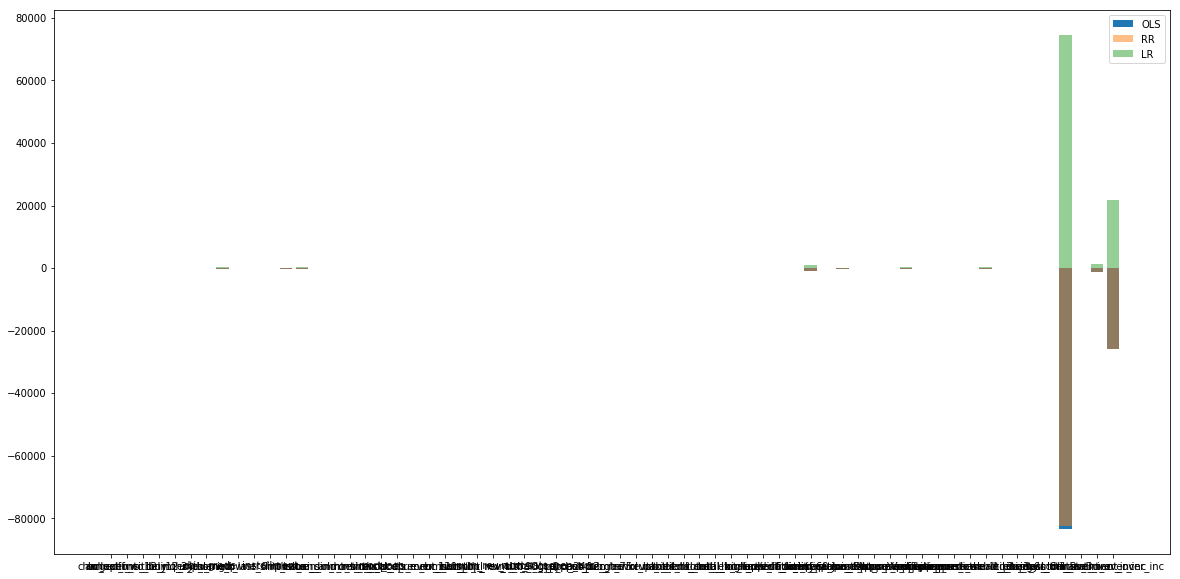

In [16]:
# your code here
plt.figure(figsize=(20,10))
plt.bar(coef_df["feature"],[-abs(x) for x in coef_df["OLS"].values],label='OLS',alpha=1.0)
plt.bar(coef_df["feature"],-abs(coef_df["RR"]),label='RR',alpha=0.5)
plt.bar(coef_df["feature"],abs(coef_df["LR"]),label='LR',alpha=0.5)
plt.yscale("linear")

plt.legend()
plt.show()

In [17]:
coef_df[abs(coef_df['OLS'])>100]

,feature,OLS,RR,LR
3,collections_12_mths_ex_med,-108.576,-108.593,-108.713
7,grade,-345.284,-345.252,-345.067
11,int_rate,155.93,155.948,156.333
12,issue_d,461.389,461.383,461.373
31,pub_rec,-110.444,-110.455,-110.497
44,application_type_Joint App,975.317,975.149,973.471
45,term_ 60 months,-142.197,-142.745,-152.152
46,verification_status_Source Verified,-151.372,-151.372,-151.419
47,verification_status_Verified,-137.624,-137.61,-137.531
48,purpose_debt_consolidation,-114.214,-114.227,-113.628


# Advanced Models
We continue to have problems with multicolinearity which may be contributing to some of the problems we are seeing in the data. I am going to try additional models that may be more suitable.

Because of the sheer size of our dataset, the following block of code take a long time to run. I ran one with full datasets without much luck. To reduce the runtime, I pulled a random sample from the dataset.

In [18]:
sample_percent = .05 # I put this ridiculouly low to ensure code would compile. I will run again overnight with a 
# larger number for additional insights.
X_train_sample = X_train.reset_index(drop=True).sample(int(len(X_train)*sample_percent),random_state=42)
y_train_sample = y_train.reset_index(drop=True).iloc[X_train_sample.index]

In [19]:
neu_net = Sequential([
    Dense(800, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(800, activation='relu'),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(1, activation='relu')
])
neu_net.compile(loss='mean_absolute_error', optimizer='adam')
neu_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 800)               52000     
_________________________________________________________________
dense_2 (Dense)              (None, 800)               640800    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               320400    
_________________________________________________________________
dense_4 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 401       
Total params: 1,334,401
Trainable params: 1,334,401
Non-trainable params: 0
_________________________________________________________________


In [20]:
#neu_net.fit(X_train_sample,y_train_sample, epochs=20, batch_size=64, validation_split = .25)
# I was not seeing improvement between epochs. This is not sutiable data for neural net

I don't see an improvement in the loss function. I'm going to try alternative methods.

In [ ]:
RF_model = RandomForestRegressor(10)
RF_model.fit(X_train_sample,y_train_sample)
RF_model.score(X_test,y_test)

0.0389345614664689

In [ ]:
size = []
avg_score = []
sd_score = []
for i in range(5,30):
    s = i * 4
    size += [s]
    RF_model = RandomForestRegressor(s)
    cv = cross_val_score(RF_model,X_train_sample,y_train_sample,cv=6,n_jobs=4)
    avg_score +=  [np.average(cv)]
    sd_score += [np.std(cv)]
    print(i,'complete')
    print(avg_score,'avg_score')
    

Score stopped at around .12. Additional features do not enhance random forest. Using crossvalidation on Pavan's model.

In [ ]:
plt.plot(size,avg_score)
bound = []
for i in range(len(size)):
    bound += [avg_score[i]+sd_score[i]]
plt.plot(size,bound,c='orange')

bound = []
for i in range(len(size)):
    bound += [avg_score[i]-sd_score[i]]
plt.plot(size,bound,c='orange')